In [94]:
import numpy as np  
import pandas as pd 
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from nltk.corpus import stopwords   
from sklearn.model_selection import train_test_split
import warnings
pd.set_option("display.max_colwidth", 100)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Read**

In [72]:
df = pd.read_csv("economic-headline.csv", delimiter="~")
df.drop_duplicates()
df.dropna(axis=0,inplace=True)
df = df[:5000]
print(df.shape)
df.head()

(5000, 2)


,text,summary
0,"program inovatif seperti business matching dan referral, melalui dukungan induk usahanya, yakni ...",Program business matching yang diperkenalkan di Indonesia diharapkan dapatkan pelaku usaha kedua...
1,"Di bawah koordinasi Kementerian Investasi dan Hilirisasi/BKPM, para pemangku kepentingan di sekt...",Rapat Koordinasi Nasional (Rakornas) Investasi 2024 pada Rabu (11/12) di Jakarta . Rakornas ini ...
2,Kementerian Keu­­­angan baru saja merilis data terkait de­­­­ngan kinerja APBN dan per­­­ekonomi...,"Pembiayaan APBN mengalami defisit sebesar Rp401,8 triliun atau 1,81% dari PDB . Kinerja APBN san..."
3,Kementerian Investasi dan Hilirisasi/Badan Koordinasi Penanaman Modal (BKPM) menyelenggarakan ac...,Kementerian Investasi dan Hilirisasi/Badan Koordinasi Penanaman Modal (BKPM) menyelenggarakan ac...
4,"Penjabat Gubernur Papua Tengah, Anwar Harun Damanik menetapkan Upah Minimum Provinsi (UMP) provi...","Anwar Harun Damanik menetapkan Upah Minimum Provinsi (UMP) provinsi itu pada tahun 2025 naik 6,5..."


In [73]:
print(f'Text: {df['text'][:10]}')
print(f'Summary: {df['summary'][:10]}')

Text: 0    program inovatif seperti business matching dan referral, melalui dukungan induk usahanya, yakni ...
1    Di bawah koordinasi Kementerian Investasi dan Hilirisasi/BKPM, para pemangku kepentingan di sekt...
2    Kementerian Keu­­­angan baru saja merilis data terkait de­­­­ngan kinerja APBN dan per­­­ekonomi...
3    Kementerian Investasi dan Hilirisasi/Badan Koordinasi Penanaman Modal (BKPM) menyelenggarakan ac...
4    Penjabat Gubernur Papua Tengah, Anwar Harun Damanik menetapkan Upah Minimum Provinsi (UMP) provi...
5    BNI Kanwil 07 Fokus dalam melakukan pembiayaan pada sektor ekonomi utama di Sulsel di mana 43% p...
6    PT Sarana Multi Infrastruktur (Persero) mengungkap capaian dari pembiayaan program Pemulihan Eko...
7    End Press Briefing, Kamis (12/12/2024). Melihat lembaga internasional lainnya seperti IMF dan Wo...
8    sektor utama seperti pertambangan, industri pengolahan, dan konstruksi. Dia mengungkapkan bahwa ...
9    desa ekonomi kreatif. “Ini adalah wujud sine

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 5018
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     5000 non-null   object
 1   summary  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


# **Cleaning**

In [75]:
stop_words = set(stopwords.words('indonesian'))

In [76]:
def text_cleaner(text):
    newtxt = text.lower()
    newtxt = BeautifulSoup(newtxt, "lxml").text
    newtxt = re.sub(r'\([^)]*\)', '', newtxt)
    newtxt = re.sub('"','', newtxt)
    newtxt = re.sub(r"'s\b","",newtxt)
    newtxt = re.sub("[^a-zA-Z]", " ", newtxt) 
    tokens = [i for i in newtxt.split() if not i in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for i in df['text']:
    cleaned_text.append(text_cleaner(i))

C:\Users\maxce\AppData\Local\Temp\ipykernel_21908\2908878634.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newtxt = BeautifulSoup(newtxt, "lxml").text


In [77]:
def summary_cleaner(text):
    newtxt = text.lower()
    newtxt = re.sub('"','', newtxt)
    newtxt = re.sub(r"'s\b","",newtxt)
    newtxt = re.sub("[^a-zA-Z]", " ", newtxt) 
    tokens = newtxt.split()
    newtext=''
    for i in tokens:
        if len(i)>1:                                 
            newtext=newtext+i+' '  
    return newtext

cleaned_summary = []
for i in df['summary']:
    cleaned_summary.append(summary_cleaner(i))

In [78]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

C:\Users\maxce\AppData\Local\Temp\ipykernel_21908\2504870128.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned_summary'].replace('', np.nan, inplace=True)


In [79]:
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : 'START '+ x + ' END')

In [80]:
for i in range(3):
    print(f"Text: {df['cleaned_text'][i]}")
    print(f"Summary: {df['cleaned_summary'][i]}")
    print("\n")

Text: program inovatif business matching referral dukungan induk usahanya kasikornbank salah bank terbesar thailand presiden direktur bank maspion kasemsri charoensiddhi peran bank maspion jembatan ekonomi indonesia thailand selaras strategi kbank sukses mendukung pengembangan segmen usaha menengah negaranya program business matching diperkenalkan indonesia diharapkan membantu pelaku usaha negara menemukan mitra strategis memperluas pasar membantu menemukan mitra matchmaker merujuk bertemu berdiskusi membangun kesepakatan bisnis kamis business matching bank maspion aktif mendorong program referral nasabah thailand informasi peluang investasi indonesia bank maspion memfasilitasi pertemuan bisnis
Summary: START program business matching yang diperkenalkan di indonesia diharapkan dapatkan pelaku usaha kedua negara menemukan strategis bank maspion tidak hanya memfasilitasi pertemuan bisnis  END


Text: koordinasi kementerian investasi hilirisasi bkpm pemangku kepentingan sektor investasi d

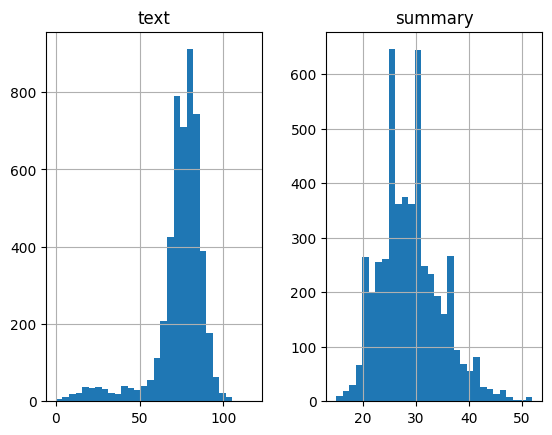

In [81]:
text_word_count = []
summary_word_count = []

for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins=30)
plt.show()

In [82]:
TEXT_MAX_LENGTH = 80
SUMMARY_MAX_LENGTH = 30

# **Split**

In [83]:
x = df['cleaned_text']
y = df['cleaned_summary']

x_train,x_val,y_train,y_val=train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)

In [84]:
x_tokenizer = Tokenizer()
y_tokenizer = Tokenizer()

x_tokenizer.fit_on_texts(list(x_train))
y_tokenizer.fit_on_texts(list(y_train))

x_train = x_tokenizer.texts_to_sequences(x_train) 
y_train = y_tokenizer.texts_to_sequences(y_train)
x_val = x_tokenizer.texts_to_sequences(x_val)
y_val = y_tokenizer.texts_to_sequences(y_val) 

x_train = pad_sequences(x_train,  maxlen=TEXT_MAX_LENGTH, padding='post') 
y_train  = pad_sequences(y_train, maxlen=SUMMARY_MAX_LENGTH, padding='post')
x_val = pad_sequences(x_val, maxlen=TEXT_MAX_LENGTH, padding='post')
y_val = pad_sequences(y_val, maxlen=SUMMARY_MAX_LENGTH, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1
y_voc_size = len(y_tokenizer.word_index) +1

# **Model**

In [85]:
K.clear_session() 
latent_dim = 256

encoder_inputs = Input(shape=(TEXT_MAX_LENGTH,))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_output])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 256)   │  5,199,104 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 80, 512), │  1,050,624 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  2,849,792 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ concatenate[0][0… │
│                     │ 512), (None,      │            │ concatenate_1[0]… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 512) │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None,      │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │ 1024)             │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 11,410,300 │ concat_layer[0][… │
│ (TimeDistributed)   │ 11132)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,084,732 (84.25 MB)

 Trainable params: 22,084,732 (84.25 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer = Adam(learning_rate=0.01) , loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [87]:
history = model.fit(
    [x_train, y_train[:, :-1]],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs=20,
    callbacks=[es],
    batch_size=64,
    validation_data=(
        [x_val, y_val[:, :-1]],
        y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 73s 978ms/step - loss: 7.1804 - val_loss: 5.3901
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 5.3300 - val_loss: 4.8128
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 63s 884ms/step - loss: 4.2444 - val_loss: 4.6430
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 3.2354 - val_loss: 4.7358
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 62s 868ms/step - loss: 2.4469 - val_loss: 4.8951
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 855ms/step - loss: 1.8743 - val_loss: 5.0499
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 856ms/step - loss: 1.4739 - val_loss: 5.2274
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 60s 849ms/step - loss: 1.1906 - val_loss: 5.3919
Epoch 8: early stopping


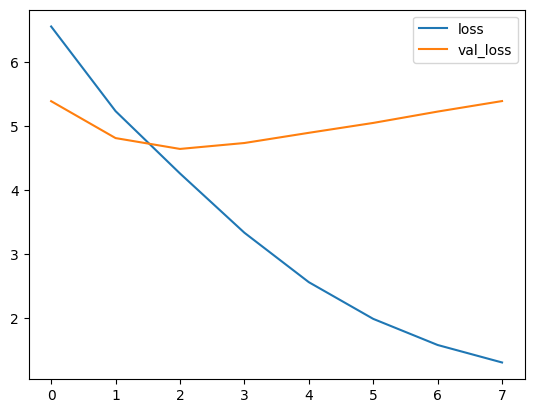

In [88]:
plt.plot(history.history['loss'], label='loss') 
plt.plot(history.history['val_loss'], label='val_loss') 
plt.legend() 
plt.show()

In [89]:
encoder_model = Model(encoder_inputs, [encoder_output, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim * 2,))
decoder_state_input_c = Input(shape=(latent_dim * 2,))
decoder_input = Input(shape=(1,))

dec_emb2 = dec_emb_layer(decoder_input)
decoder_lstm_output, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out2 = attn_layer([decoder_lstm_output, encoder_output])
decoder_concat_input2 = Concatenate(axis=-1)([decoder_lstm_output, attn_out2])

decoder_output2 = decoder_dense(decoder_concat_input2)

decoder_model = Model([decoder_input, decoder_state_input_h, decoder_state_input_c, encoder_output], 
                      [decoder_output2, state_h2, state_c2])

In [90]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [91]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))

    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, e_h, e_c, e_out])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index.get(sampled_token_index, '')
        
        if sampled_token != 'end' and sampled_token != '':
            decoded_sentence += ' ' + sampled_token

        if sampled_token == 'end' or len(decoded_sentence.split()) >= (SUMMARY_MAX_LENGTH - 1):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence.strip()

In [92]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['start'] and i != target_word_index['end']:
            newString += reverse_target_word_index[i] + ' '
    return newString.strip()  # Remove any trailing space

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        # Skip the padding token (0)
        if i != 0:
            newString += reverse_source_word_index[i] + ' '
    return newString.strip()

In [98]:
for i in range(1):
    print("Review:", seq2text(x_val[i]))
    print("Original summary:", seq2summary(y_val[i]))
    predicted_summary = decode_sequence(x_val[i].reshape(1, TEXT_MAX_LENGTH))
    print("Predicted summary:", predicted_summary)
    
    print("\n")

Review: penyesuaian tarif krl salah keputusan masyarakat wilayah urban pengguna tarif krl boros subsidi dinikmati orang wacana kali kementerian perhubungan pemangku kepentingan terkait bahas stakeholders pastikan realisasi juru bicara kemenhub irawati senin pembahasan tindaklanjut wacana terkait penyesuaian tarif krl kemenhub rutin mengevaluasi pemberlakuan tarif krl jabodetabek merespons perusahaan operator krl kereta commuter indonesia kai commuter mengikuti keputusan kemenhub corporate secretary kai commuter anne purba perusahaan bertugas mengelola moda transportasi krl jabodetabek baca jug
Original summary: penyesuaian tarif krl menjadi salah satu keputusan yang masyarakat wilayah urban khususnya pengguna wacana tersebut pertama kali diungkapkan oleh kementerian perhubungan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [65]:
def preprocess_input_text(input_text, tokenizer, max_len):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    return input_seq

def generate_predicted_summary(input_text):
    input_seq = preprocess_input_text(input_text, x_tokenizer, TEXT_MAX_LENGTH)
    
    predicted_summary = decode_sequence(input_seq)
    
    return predicted_summary

In [ ]:
input_text = """"
Ekonomi kerakyatan menjadi basis utama perekonomian Indonesia agar keadilan sosial bagi seluruh rakyat Indonesia dapat terwujud. Atas dasar itu, negara juga mewajibkan setiap perusahaan di Indonesia untuk mendukung ekonomi kerakyatan. Hal tersebut juga menjadi komitmen PT Astra International Tbk, yang secara serius membangun ekosistem ekonomi kerakyatan, dan secara nyata terbukti memberi dampak terhadap peningkatan kesejahteraan masyarakat. 
Oleh karena itu detikcom Awards 2024 memberikan anugerah Perusahaan Multi Sektoral Terkemuka Penggerak Ekonomi Rakyat untuk Astra International.  
Astra berkeinginan untuk berkontribusi dalam memperkuat ketahanan perekonomian Indonesia yang mendukung masyarakat yang inklusif dan sejahtera. 
Astra memiliki rekam jejak kontribusi publik dan sosial yang baik melalui empat pilar, yang terdiri dari kesehatan, pendidikan, lingkungan, dan kewirausahaan. Serta sembilan yayasan yang turut berkontribusi untuk pertumbuhan ekonomi Indonesia sekaligus mendukung masyarakat yang inklusif dan sejahtera. Dilaksanakan pertama kali pada tahun 2010, program Astra Semangat Astra Terpadu Untuk (SATU) Indonesia Awards, telah mengapresiasi 657 pemuda Indonesia dari masing-masing bidang, terdiri dari 92 penerima tingkat nasional dan 565 penerima tingkat provinsi. Program SATU Indonesia Awards dikolaborasikan dengan berbagai kegiatan komunitas Astra melalui 200 Kampung Berseri Astra dan 1.196 Desa Sejahtera Astra di 35 provinsi di seluruh Indonesia. Astra adalah salah satu perusahaan publik terbesar di Indonesia, yang terdiri dari 291 anak perusahaan, ventura bersama serta entitas asosiasi, didukung lebih dari 200.000 karyawan. Model bisnis perusahaan yang terdiversifikasi menciptakan sinergi dan peluang di seluruh sektor industri termasuk Otomotif, Jasa Keuangan, Alat Berat, Pertambangan, Konstruksi & Energi, Agribisnis, Infrastruktur dan Logistik, Teknologi Informasi, dan Properti. Astra mempunyai kerangka sustainability baru yang di dalamnya terdapat Astra 2030 Sustainability Aspirations untuk memandu perjalanan transisi Grup Astra dalam menjadi perusahaan yang lebih sustainable pada tahun 2030 dan seterusnya.
"""

# Generate the predicted summary for the provided input text
predicted_summary = generate_predicted_summary(input_text[:80])

# Print the predicted summary
print(f"Input Text: {input_text}")
print("Predicted Summary:", predicted_summary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input Text: "
Ekonomi kerakyatan menjadi basis utama perekonomian Indonesia agar keadilan sosial bagi seluruh rakyat Indonesia dapat terwujud. 
Atas dasar itu, negara juga mewajibkan setiap perusahaan di Indonesia untuk mendukung ekonomi kerakyatan. 
Hal tersebut juga menjadi komitmen PT Astra International Tbk, yang secara serius membangun ekosistem ekonomi kerakyatan, 
dan secara nyata t